<a href="https://colab.research.google.com/github/Talendar/stocks_prices_prediction/blob/main/stocks_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Stocks Prices with Deep Learning**

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output, display, Javascript

import tensorflow as tf
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.callbacks import Callback

#!pip install investpy
#import investpy

!pip install yahooquery
from yahooquery import Ticker

In [3]:
NUM_SESSIONS = 20  # number of previous trading sessions the model will analyse in order to make a prediction
NORMALIZE_LABELS = True

TRAIN_PC, VAL_PC, TEST_PC = 0.85, 0.1, 0.05
assert (TRAIN_PC + VAL_PC + TEST_PC) == 1

LABELS_NAMES = [    # values that the model will try to predict
    "open", "low", "high",
]

In [4]:
mape = tf.keras.metrics.MeanAbsolutePercentageError()
mae = tf.keras.metrics.MeanAbsoluteError()
mse = tf.keras.metrics.MeanSquaredError()


class ClearCallback(Callback):
    """ Handles the cleaning of the log during the training of a model. """

    def on_epoch_end(self, epoch, logs=None):
        """ Clears the log. Called when a training epoch ends. """
        clear_output(wait=True)


def eval_plot(predictions, labels, start_date, plot_samples, title):
    # sampling
    idx = np.random.randint(len(labels.index) - plot_samples) \
          if start_date == "random" \
          else labels.index.index(start_date)

    sl = slice(idx, idx + plot_samples)
    predictions, labels = predictions[sl], labels[sl]

    # plotting
    fig = plt.figure(figsize=(18, 9))
    fig.subplots_adjust(top=2.6)
    fig.suptitle(title, fontsize=22, color="#E0E0E0", x=0.52, y=2.76)

    for i, col in enumerate(labels.columns):
        col_title = "Opening Price" if col == "open" else \
                    "Closing Price" if col == "close" else \
                    "Lowest Price"  if col == "low" else \
                    "Highest Price" if col == "high" else col

        # error bars
        bars_errors = [[], []]
        for d in (labels[col] - predictions[col]).values:
            if d > 0:
                bars_errors[1].append(d)
                bars_errors[0].append(0)
            else:
                bars_errors[0].append(-d)
                bars_errors[1].append(0)

        # config
        ax_graph = fig.add_subplot(len(labels.columns), 1, i+1)
        ax_graph.tick_params(axis='both', which='major', labelsize=12, color="#DCDCDC")
        ax_graph.set_title(f"\n{col_title}\n", fontsize=18, color="#E0E0E0")
        ax_graph.set_ylabel('Ibovespa\n', fontsize=16, color="#E0E0E0")

        # plot
        ax_graph.plot(labels[col].index, labels[col].values, 
                marker='o', c='#2ca02c', 
                label='Labels', linewidth=3)
        ax_graph.errorbar(predictions[col].index, predictions[col].values, ecolor="#ff0000",
                    yerr=bars_errors, linestyle="--", elinewidth=2,
                    marker='s', label='Predictions', c='#ff7f0e', 
                    alpha=0.6, linewidth=3)[-1][0].set_linestyle(':')
        ax_graph.legend(fontsize=16)


def eval_print(results):
    print("#"*25)
    for col in results:
        print(
            f"\n[> {col.upper()} <]\n" +
            f"   . MAE:  {results[col]['mae'] : .0f}\n" +
            f"   . MAPE: {results[col]['mape'] : .4f}%\n"
            f"   . MSE:  {results[col]['mse'] : .0f}\n" + 
            "\n" + "#" * 25
        )


def full_eval(model, dataset, denorm_labels, title, start_date="random", plot_samples=30):
    # predictions
    predictions = model.predict(dataset)
    denorm_labels = denorm_labels[:len(predictions)]
    predictions = pd.DataFrame(data=predictions, 
                               index=denorm_labels.index,
                               columns=denorm_labels.columns)
    if NORMALIZE_LABELS:
        predictions = denormalize(predictions,
                                  dmin=norm_l_min.values, 
                                  dmax=norm_l_max.values)
    
    # plot
    eval_plot(predictions, denorm_labels, start_date, plot_samples, title)

    # results
    results = {"general": {"mae": mae(denorm_labels, predictions),
                           "mape": mape(denorm_labels, predictions),
                           "mse": mse(denorm_labels, predictions)} }
    for col in denorm_labels.columns:
        results[col] = {"mae":  mae(denorm_labels[col], predictions[col]),
                        "mape": mape(denorm_labels[col], predictions[col]),
                        "mse":  mse(denorm_labels[col], predictions[col])}
    return results

## **1) Preparing the data**

#### **1.1) Retrieving**

   [TIME INTERVAL] from 2000-01-03 to 2020-12-04
[TRADING SESSIONS] 5176

>>> DATA:


,open,low,high,close,volume
date,,,,,
2000-01-03,17098.0,16719.0,17408.0,16930.0,0.0
2000-01-04,16908.0,15851.0,16908.0,15851.0,0.0
2000-01-05,15871.0,15350.0,16302.0,16245.0,0.0
2000-01-06,16237.0,15977.0,16499.0,16107.0,0.0
2000-01-07,16125.0,16125.0,16449.0,16309.0,0.0
...,...,...,...,...,...
2020-11-30,110598.0,108829.0,110934.0,108888.0,19300000.0
2020-12-01,108897.0,108897.0,111840.0,111335.0,11324800.0
2020-12-02,111402.0,110579.0,112315.0,111814.0,9814300.0




>>> STATS:


,open,low,high,close,volume
count,5176.000000,5176.000000,5176.000000,5176.000000,5.176000e+03
mean,49797.628091,49275.988794,50326.696677,49815.819359,7.252677e+06
std,25759.821732,25546.478119,25978.224615,25774.795187,2.375996e+07
min,8397.000000,8225.000000,8513.000000,8371.000000,0.000000e+00
25%,25262.250000,24952.750000,25567.500000,25268.500000,0.000000e+00
50%,52652.500000,52094.500000,53266.500000,52646.000000,2.341400e+06
75%,64752.500000,64176.000000,65399.500000,64778.250000,3.904900e+06
max,119528.000000,118108.000000,119593.000000,119528.000000,2.322653e+08


<IPython.core.display.Javascript object>

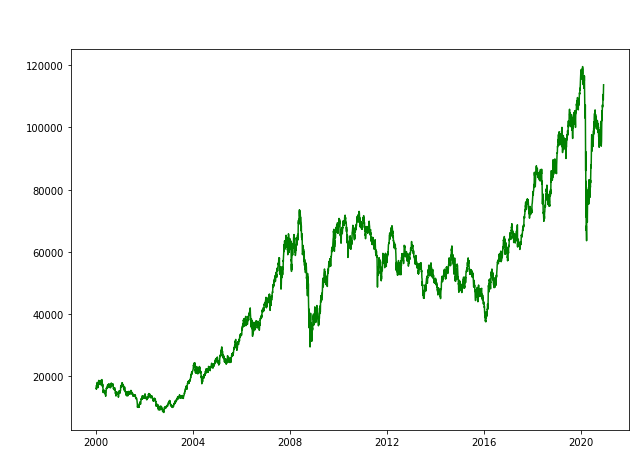

In [10]:
"""data = investpy.get_index_historical_data(index='IBOVESPA',
                                          country='Brazil',
                                          from_date='01/01/1990',
                                          to_date='03/12/2020')
                                          
data.drop("Currency", axis=1, inplace=True)
data.columns = data.columns.str.lower()"""


data = Ticker("^BVSP").history(start="2000-01-01",
                               #end="2020-12-04",
                               interval="1d")

data.drop("adjclose", axis=1, inplace=True)
data.reset_index("symbol", inplace=True, drop=True)

print("   [TIME INTERVAL] from %s to %s" % (data.index[0], data.index[-1]))
print("[TRADING SESSIONS] %d\n" % len(data))

print(">>> DATA:")
display(data)

print("\n\n>>> STATS:")
display(data.describe())

print("\n\n")
ax = data["close"].plot(figsize=(10,7), color="green")
ax.set_title("Evolution of the closing prices\n", fontsize=20, color="#ffffff");
ax.set_ylabel("Closing prices", fontsize="15", color="#ffffff");
ax.set_xlabel("Date", fontsize="15", color="#ffffff");

Javascript("google.colab.output.setIframeHeight('500px');")

#### **1.2) Splitting data**

In [11]:
def features_and_labels(data):
    return data[:-NUM_SESSIONS], data[LABELS_NAMES][NUM_SESSIONS:]


def assert_labels(data, labels):
    data, labels = data[LABELS_NAMES].values, labels.values
    for i in range(len(labels) - NUM_SESSIONS):
        assert np.array_equal(labels[i], data[i + NUM_SESSIONS])


n = len(data)
train_data, train_labels = features_and_labels(data[:int(n*TRAIN_PC)])
val_data, val_labels = features_and_labels(data[int(n*TRAIN_PC) : int(n * (TRAIN_PC + VAL_PC))])
test_data, test_labels = features_and_labels(data[int(n * (TRAIN_PC + VAL_PC)):])

print("Asserting labels... ", end="")
assert_labels(train_data, train_labels)
assert_labels(val_data, val_labels)
assert_labels(test_data, test_labels)
print("done!\n")

print("  [TRAINING RANGE] {} to {}".format(str(train_data.index[0])[:10], str(train_data.index[-1])[:10]))
print("[VALIDATION RANGE] {} to {}".format(str(val_data.index[0])[:10], str(val_data.index[-1])[:10]))
print("      [TEST RANGE] {} to {}\n".format(str(test_data.index[0])[:10], str(test_data.index[-1])[:10]))

print(f"  [TRAINING DATA SHAPE] Features: {train_data.shape}  |  Labels: {train_labels.shape}")
print(f"[VALIDATION DATA SHAPE] Features: {val_data.shape}  |  Labels: {val_labels.shape}")
print(f"      [TEST DATA SHAPE] Features: {test_data.shape}  |  Labels: {test_labels.shape}")

Asserting labels... done!

  [TRAINING RANGE] 2000-01-03 to 2017-09-08
[VALIDATION RANGE] 2017-10-09 to 2019-10-17
      [TEST RANGE] 2019-11-18 to 2020-11-05

  [TRAINING DATA SHAPE] Features: (4379, 5)  |  Labels: (4379, 3)
[VALIDATION DATA SHAPE] Features: (498, 5)  |  Labels: (498, 3)
      [TEST DATA SHAPE] Features: (239, 5)  |  Labels: (239, 3)


#### **1.3) Data normalization**

In [12]:
def min_max_norm(data, dmin=None, dmax=None):
    if dmin is None:
        dmin = data.min(axis=0)

    if dmax is None:
        dmax = data.max(axis=0)

    return (data - dmin) / (dmax - dmin), dmin, dmax


def denormalize(data, dmin, dmax):
    return (data * (dmax - dmin)) + dmin


norm_train_data, norm_f_min, norm_f_max = min_max_norm(train_data)
norm_val_data = min_max_norm(val_data, norm_f_min, norm_f_max)[0]
norm_test_data = min_max_norm(test_data, norm_f_min, norm_f_max)[0]

norm_train_labels = norm_val_labels = norm_test_labels = None
if NORMALIZE_LABELS:
    norm_train_labels, norm_l_min, norm_l_max = min_max_norm(train_labels)
    norm_val_labels = min_max_norm(val_labels, norm_l_min, norm_l_max)[0]
    norm_test_labels = min_max_norm(test_labels, norm_l_min, norm_l_max)[0]

print(">>> NORMALIZED TRAINING DATA:")
display(norm_train_data.tail())

print("\n\n>>> NORMALIZED VALIDATION DATA:")
display(norm_val_data.tail())

print("\n\n>>> NORMALIZED TEST DATA:")
display(norm_test_data.tail())

Javascript("google.colab.output.setIframeHeight('300px');")

>>> NORMALIZED TRAINING DATA:


,open,low,high,close,volume
date,,,,,
2017-09-01,0.959147,0.967867,0.973963,0.975532,0.016709
2017-09-04,0.975626,0.980618,0.972801,0.978694,0.008602
2017-09-05,0.978898,0.983029,0.988686,0.979032,0.018216
2017-09-06,0.979251,0.988130,0.995230,0.998388,0.018266
2017-09-08,0.998541,1.000000,0.995811,0.993277,0.013408




>>> NORMALIZED VALIDATION DATA:


,open,low,high,close,volume
date,,,,,
2019-10-11,1.434811,1.446584,1.465715,1.465339,0.018736
2019-10-14,1.465758,1.471607,1.464553,1.472554,0.012864
2019-10-15,1.472900,1.481097,1.475912,1.475440,0.017624
2019-10-16,1.475772,1.472890,1.482242,1.489761,0.019415
2019-10-17,1.489641,1.493076,1.488801,1.483514,0.018035




>>> NORMALIZED TEST DATA:


,open,low,high,close,volume
date,,,,,
2020-10-29,1.335734,1.316260,1.348097,1.354051,0.054698
2020-10-30,1.354333,1.318918,1.346431,1.313680,0.045823
2020-11-03,1.314233,1.325240,1.341401,1.338778,0.043880
2020-11-04,1.345318,1.356445,1.372682,1.372916,0.046088
2020-11-05,1.374207,1.385580,1.412830,1.418399,0.045014


<IPython.core.display.Javascript object>

#### **1.4) Creating a windowed data generator**

In [13]:
def make_dataset(data, labels, shuffle=True):
    return tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data, targets=labels,
        sequence_length=NUM_SESSIONS,
        sequence_stride=1,
        shuffle=shuffle,
        batch_size=32,
    )


ds_train = make_dataset(norm_train_data, 
                        norm_train_labels if NORMALIZE_LABELS else train_labels,
                        shuffle=True)
ds_val = make_dataset(norm_val_data, 
                      norm_val_labels if NORMALIZE_LABELS else val_labels,
                      shuffle=False)
ds_test = make_dataset(norm_test_data, 
                       norm_test_labels if NORMALIZE_LABELS else test_labels,
                       shuffle=False)

sample_x, sample_y = next(iter(ds_train))
print(f"Sample input shape: {sample_x.shape}")
print(f"Sample label shape: {sample_y.shape}")

Sample input shape: (32, 20, 5)
Sample label shape: (32, 3)


## **2) Defining a model**

In [14]:
class MultiLSTM(tf.keras.Model):
    """ Custom LSTM model. """

    def __init__(self, num_sessions=NUM_SESSIONS):
        super(MultiLSTM, self).__init__()
        self._num_sessions = num_sessions

        self._open_predictor = model = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(64, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),  # RELU
        ])

        self._pre_lowest = tf.keras.layers.LSTM(64, return_sequences=True)
        self._lowest_predictor = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(64, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),  # RELU
        ])

        self._pre_highest = tf.keras.layers.LSTM(64, return_sequences=True)
        self._highest_predictor = tf.keras.models.Sequential([
            tf.keras.layers.LSTM(64, return_sequences=True),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.LSTM(64, return_sequences=False),
            tf.keras.layers.Dropout(0.3),
            tf.keras.layers.Dense(1, activation="relu"),  # RELU
        ])

    def call(self, inputs, training=None):
        # calculating the opening price
        open_price = self._open_predictor(inputs, training=training)

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        open_price_exp = tf.tile(tf.expand_dims(open_price, -1),   
                                 [1, self._num_sessions, 1])

        # calculating the lowest price
        lowest_price = self._lowest_predictor(
            # appends the opening price to the end of each item in the input sequence
            tf.concat([self._pre_lowest(inputs), open_price_exp], -1),
            training=training,
        )

        # cloning prices: expanding shape from (batches, 1) to (batches, NUM_SESSIONS, 1)
        lowest_price_exp = tf.tile(tf.expand_dims(lowest_price, -1),   
                                   [1, self._num_sessions, 1])

        # calculating the highest price
        highest_price = self._highest_predictor(
            # appends the opening price and the lowest price to the end of each item in the input sequence
            tf.concat(
                [self._pre_highest(inputs), open_price_exp, lowest_price_exp], -1),
            training=training,
        )

        # returning the concatenation of the opening price, lowest price and highest price
        return tf.concat([open_price, lowest_price, highest_price], -1)

In [ ]:
# testing output shape
x, y = next(iter(ds_train))
MultiLSTM()(x)

## **3) Training the model**

137/137 [==============================] - 4s 31ms/step - loss: 7.1245e-04 - mean_absolute_error: 0.0200 - val_loss: 0.0020 - val_mean_absolute_error: 0.0344





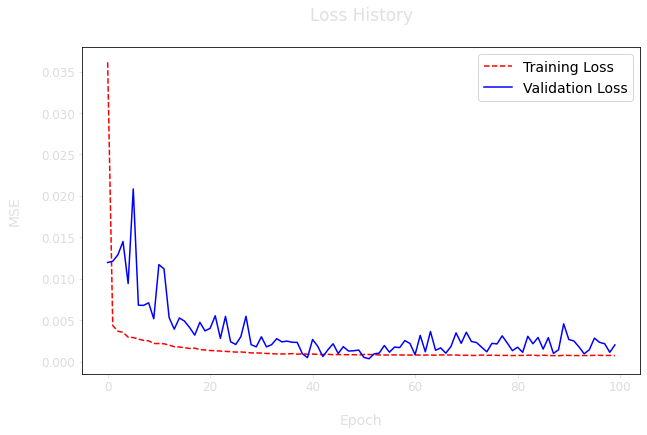

In [15]:
# building and compiling
model = MultiLSTM()
model.compile(loss=tf.losses.MeanSquaredError(),
              optimizer=tf.optimizers.Adam(learning_rate=1e-3),
              metrics=[tf.metrics.MeanAbsoluteError()]) 
                       #tf.metrics.MeanAbsolutePercentageError()])

# training
epochs = 100
history = model.fit(ds_train, validation_data=ds_val,
                    epochs=epochs,
                    callbacks=[ClearCallback()])

# visualizing loss history
print("\n\n")
plt.rc('xtick',labelsize=12, color="#DCDCDC")
plt.rc('ytick',labelsize=12, color="#DCDCDC")
plt.rcParams.update({'legend.fontsize': 14, 'legend.handlelength': 2})

plt.figure(figsize=(10, 6))
plt.plot(range(epochs), history.history["loss"], 'r--')
plt.plot(range(epochs), history.history["val_loss"], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])

plt.title("Loss History\n", fontsize=17, color="#E0E0E0")
plt.ylabel('MSE\n', fontsize=14, color="#E0E0E0")
plt.xlabel('\nEpoch', fontsize=14, color="#E0E0E0")
plt.show();

## **3) Evaluating the model**

#### **3.1) Training data**

     Training Data

#########################

[> GENERAL <]
   . MAE:   719
   . MAPE:  2.3766%
   . MSE:   830650

#########################

[> OPEN <]
   . MAE:   719
   . MAPE:  2.3763%
   . MSE:   830506

#########################

[> LOW <]
   . MAE:   719
   . MAPE:  2.3765%
   . MSE:   830621

#########################

[> HIGH <]
   . MAE:   719
   . MAPE:  2.3766%
   . MSE:   830650

#########################


<IPython.core.display.Javascript object>

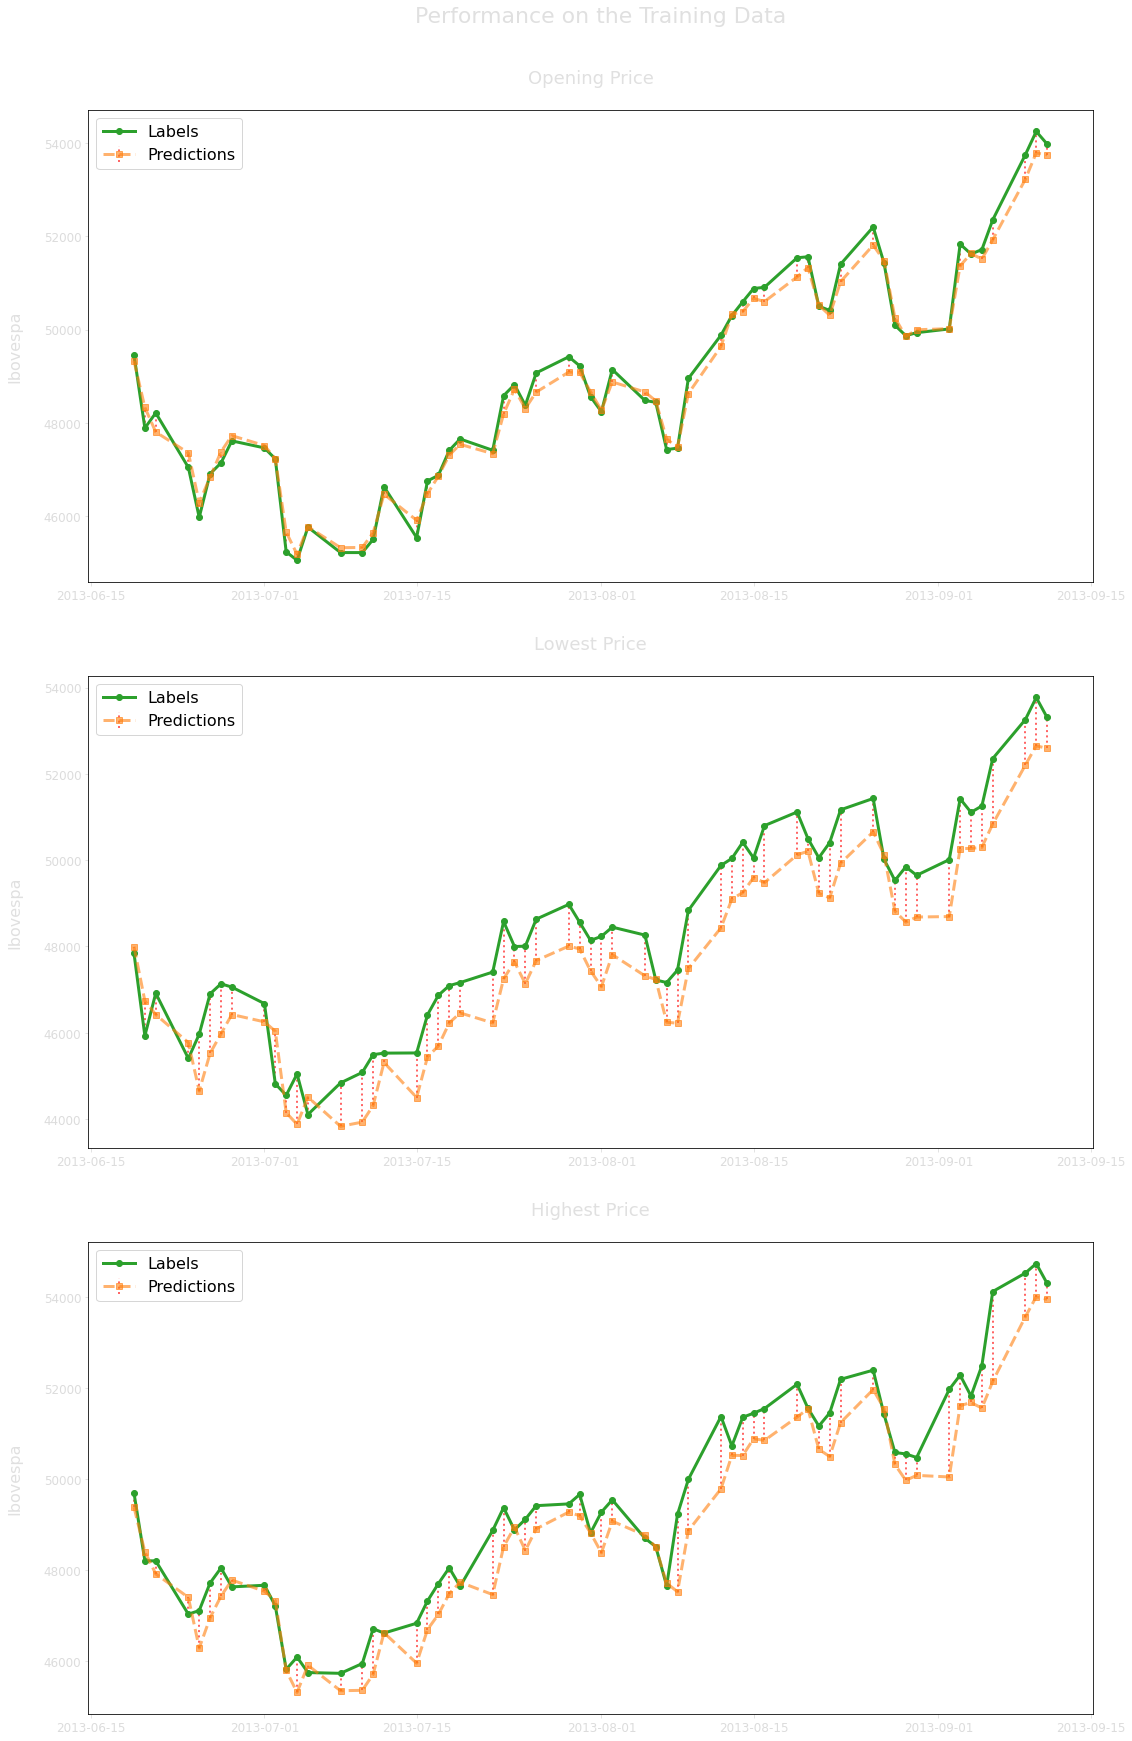

In [16]:
train_results = full_eval(
    model=model, 
    dataset= make_dataset(norm_train_data, 
                          norm_train_labels if NORMALIZE_LABELS else train_labels, 
                          shuffle=False), 
    denorm_labels=train_labels, 
    title="Performance on the Training Data\n",
    start_date="random",
    plot_samples=60,
)

print("     Training Data\n")
eval_print(train_results)
Javascript("google.colab.output.setIframeHeight('600px');")

#### **3.2) Validation data**

     Validation Data

#########################

[> GENERAL <]
   . MAE:   882
   . MAPE:  2.4011%
   . MSE:   1683939

#########################

[> OPEN <]
   . MAE:   882
   . MAPE:  2.4006%
   . MSE:   1683614

#########################

[> LOW <]
   . MAE:   883
   . MAPE:  2.4011%
   . MSE:   1687200

#########################

[> HIGH <]
   . MAE:   883
   . MAPE:  2.4012%
   . MSE:   1688751

#########################


<IPython.core.display.Javascript object>

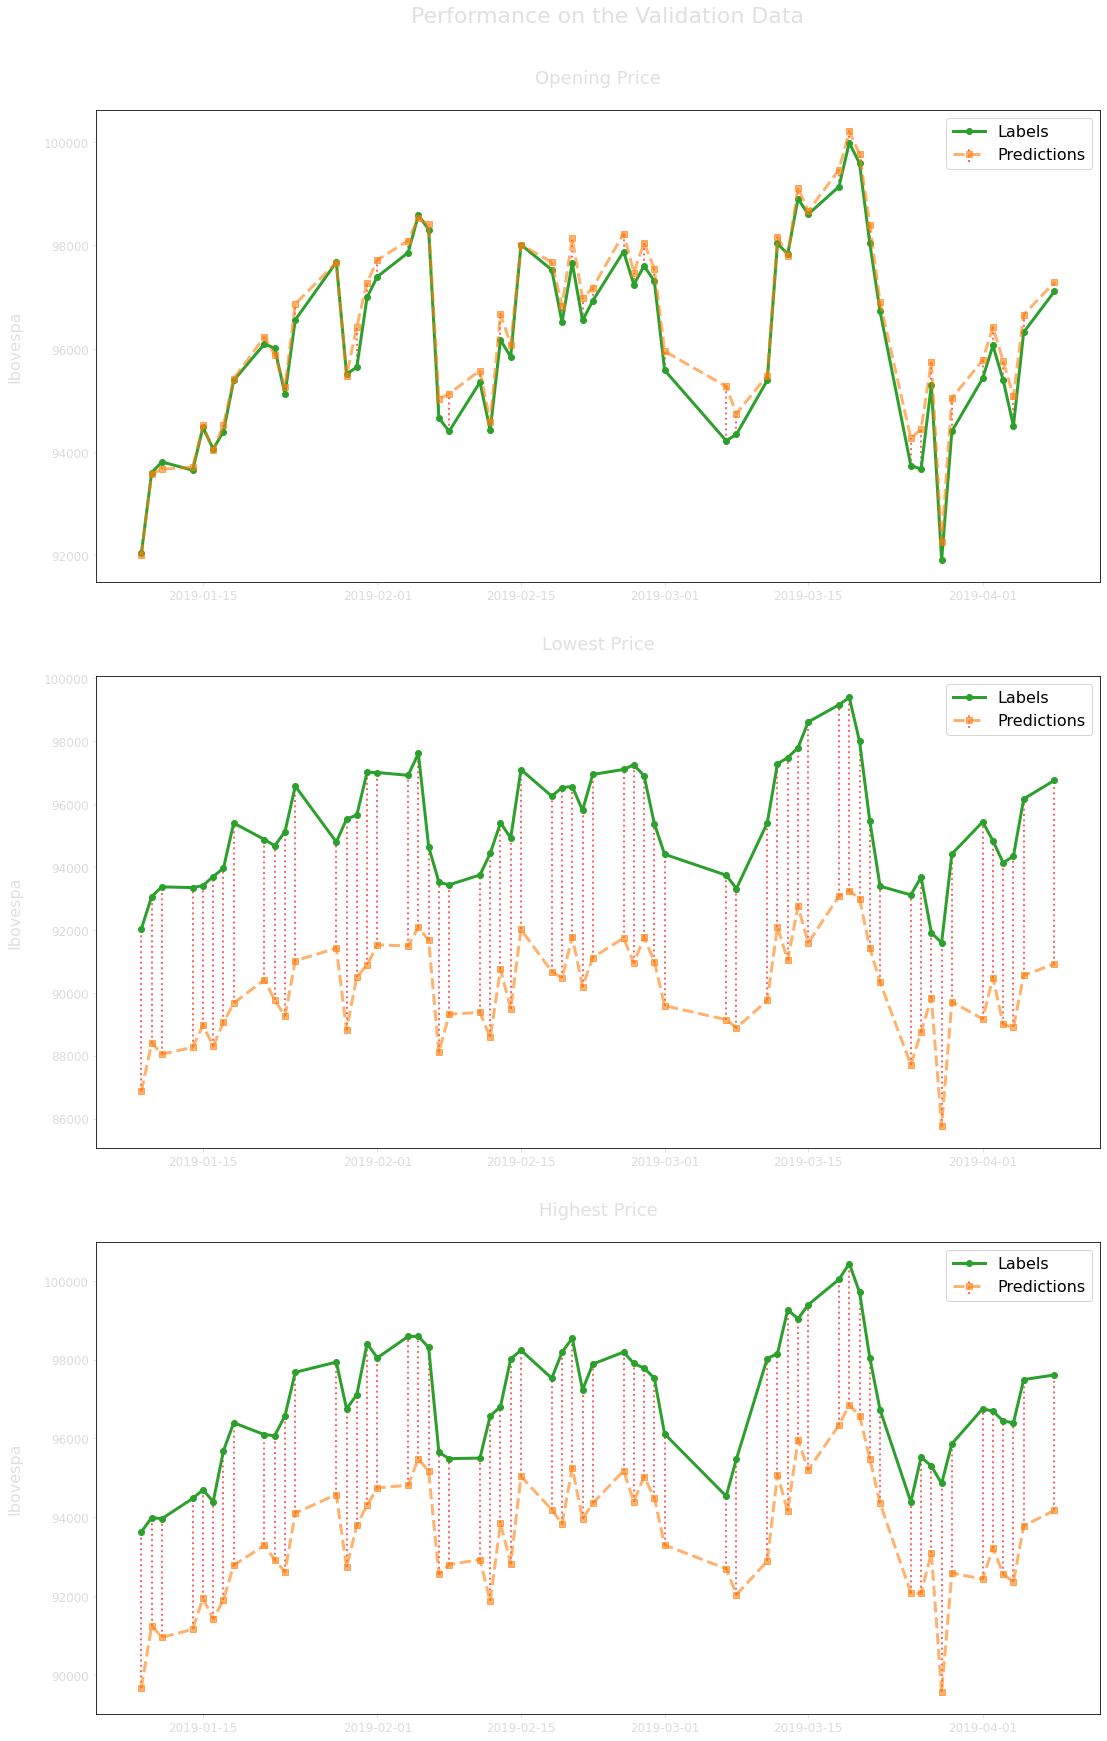

In [17]:
val_results = full_eval(
    model=model, 
    dataset= make_dataset(norm_val_data, 
                          norm_val_labels if NORMALIZE_LABELS else val_labels, 
                          shuffle=False), 
    denorm_labels=val_labels, 
    title="Performance on the Validation Data\n",
    start_date="random",
    plot_samples=60,
)

print("     Validation Data\n")
eval_print(val_results)
Javascript("google.colab.output.setIframeHeight('600px');")

#### **3.3) Test data**

      Test Data

#########################

[> GENERAL <]
   . MAE:   995
   . MAPE:  2.4491%
   . MSE:   2493868

#########################

[> OPEN <]
   . MAE:   995
   . MAPE:  2.4487%
   . MSE:   2493474

#########################

[> LOW <]
   . MAE:   996
   . MAPE:  2.4494%
   . MSE:   2501055

#########################

[> HIGH <]
   . MAE:   996
   . MAPE:  2.4497%
   . MSE:   2504364

#########################


<IPython.core.display.Javascript object>

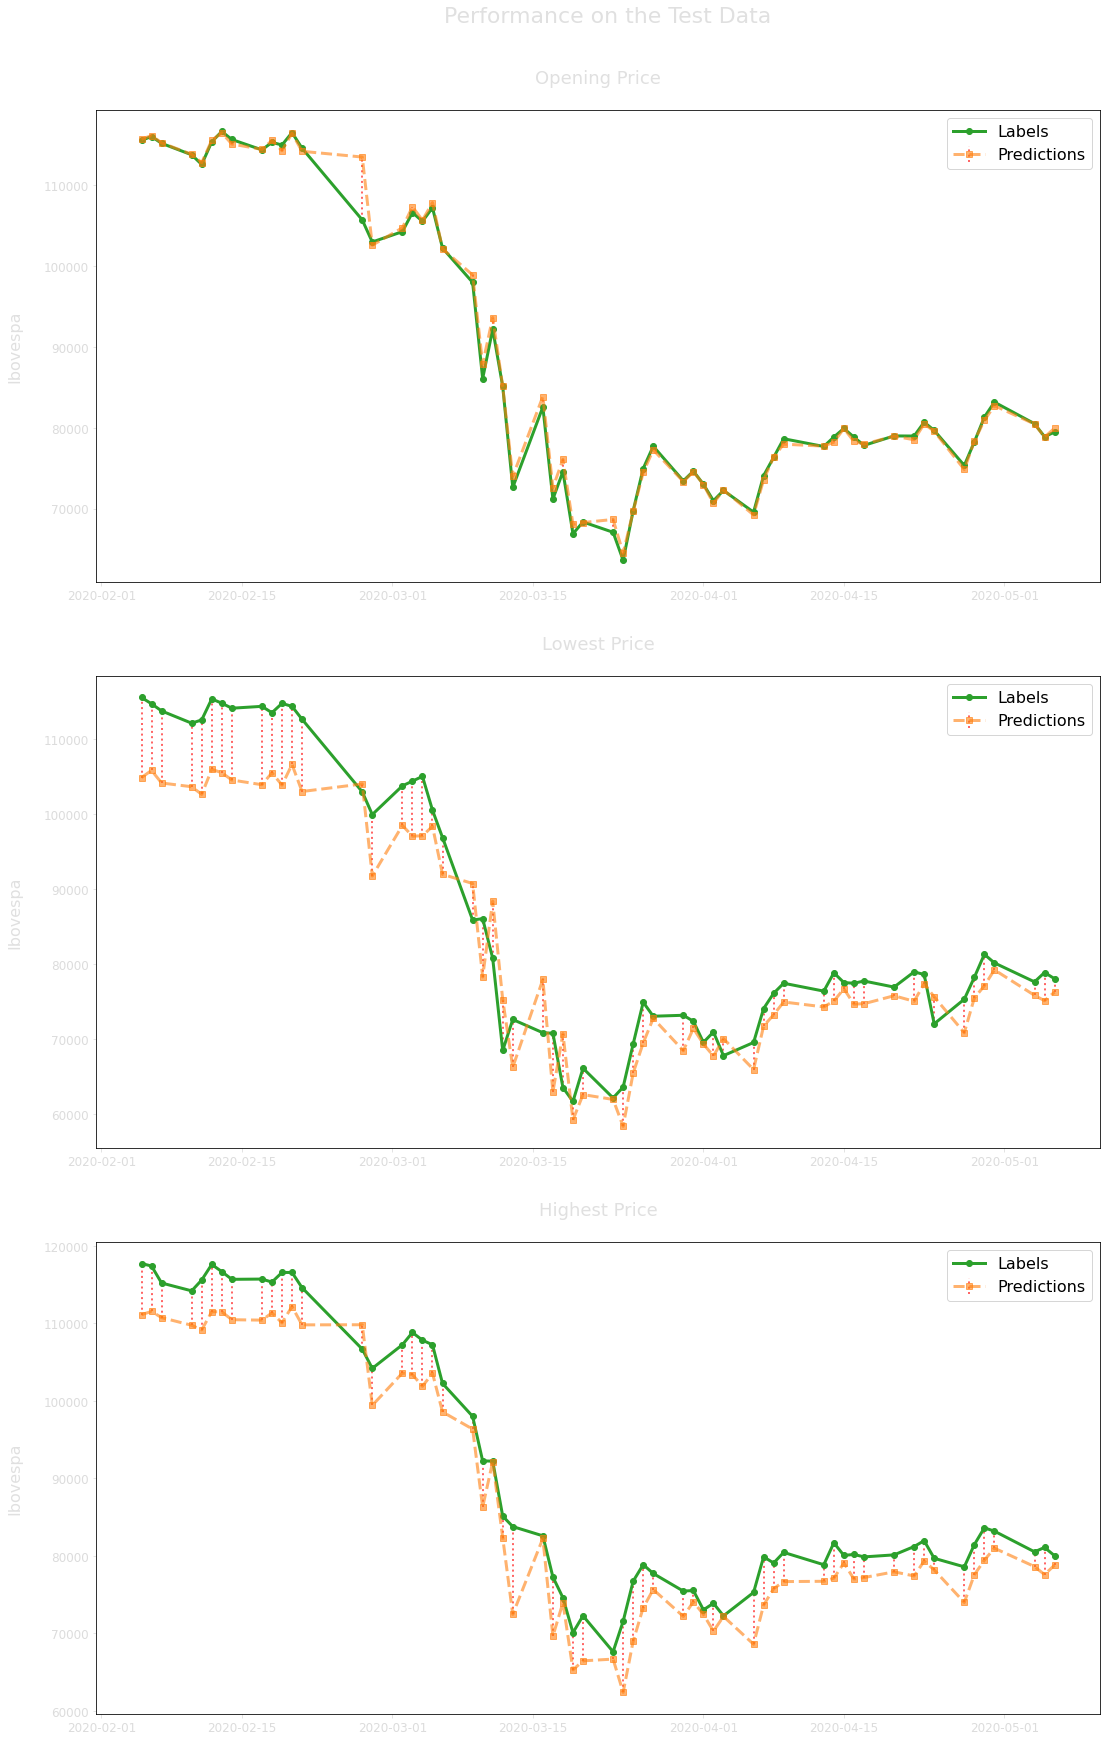

In [18]:
test_results = full_eval(
    model=model, 
    dataset= make_dataset(norm_test_data, 
                          norm_test_labels if NORMALIZE_LABELS else test_labels, 
                          shuffle=False), 
    denorm_labels=test_labels, 
    title="Performance on the Test Data\n",
    start_date="random",
    plot_samples=60,
)

print("      Test Data\n")
eval_print(test_results)
Javascript("google.colab.output.setIframeHeight('600px');")